# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use a version of the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by
\begin{cases}
Y_t = \mu + e^{-V_t} W_t, \\
\mathrm{d}V_t = \kappa \left (\gamma - V_t \right ) \mathrm{d}t + \sigma \mathrm{d}B_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$.$\{V_t\}$ is a one-dimensional Wiener processes, wheras $\{W_t\}$ is assumed to follow a Laplace distribution. 

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter.timeseries import StateSpaceModel, OrnsteinUhlenbeck, AffineObservations, Parameter

Next, we define the governing dynamics

In [2]:
import torch


def go(vol, level, beta):
    return level


def fo(vol, level, beta):
    return torch.exp(-vol)

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \gamma \sim \mathcal{N}(0, 1), \\
    \mu \sim \mathcal{N}(0, 0.5), \\
    \kappa \sim \mathcal{E}(10), \\
    \sigma \sim \mathcal{E}(5). \\
\end{cases}
To do this, we need to import the necessary distributions.

In [3]:
from torch.distributions import Exponential, Normal, Laplace

Next, we define the model in terms of code and get

In [4]:
logvol = OrnsteinUhlenbeck(Exponential(10.), Normal(0., 1.), Exponential(5))
obs = AffineObservations((go, fo), (Normal(0., 0.5), 0.), Laplace(0., 1.))

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick the S&P500.

In [5]:
import numpy as np
import pandas as pd
from yfinance import Ticker

spx = Ticker('^GSPC')
y = np.log(1 + spx.history(start='2000-01-01').Close.pct_change().iloc[1:]) * 100

We plot the data to get an idea of its volatility

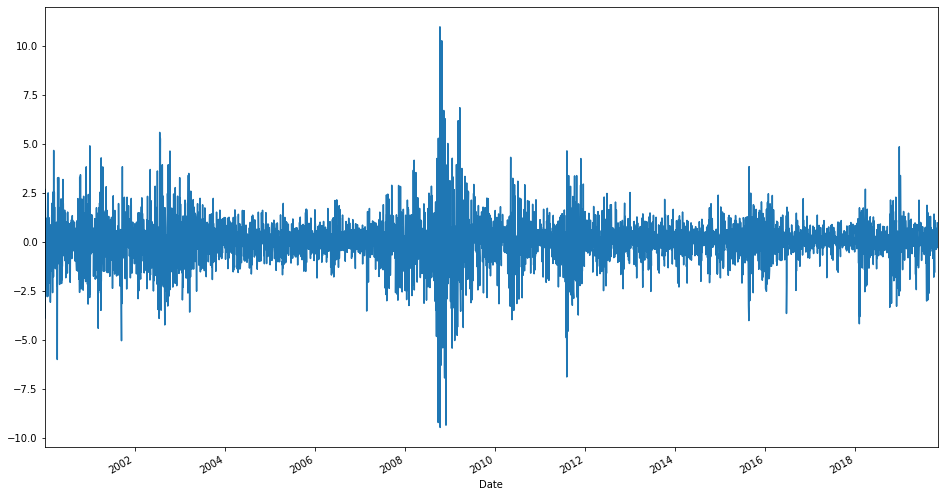

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use the SMC2FW algorithm by Y Zhou. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use the bootstrap. Importing the relevant classes, we get

In [7]:
from pyfilter.algorithms import SMC2FW
from pyfilter.filters import APF

Let's now fit the model to the data, but first moving it to the GPU (GTX 1070)

In [8]:
from pyfilter.resampling import multinomial

predictions = 10
training = torch.from_numpy(y.values).float().cuda()

algs = list()
for i in range(2):
    filt = APF(stockmodel.copy(), 250, resampling=multinomial)
    alg = SMC2FW(filt, 2000, switch=2000).to_('cuda:0').initialize()
    
    alg.fit(training)
    
    algs.append(alg)

H:\Anaconda3\lib\site-packages\pyfilter\algorithms\base.py:146: UserWarning: SMC2FW is an experimental algorithm, use at own risk
  warnings.warn('{:s} is an experimental algorithm, use at own risk'.format(str(obj)))
SMC2: 100%|████████████████████████████████████████████████████████████████████████| 4991/4991 [03:01<00:00, 27.45it/s]


Next, we plot the posterior distributions. The first three correspond to the reversion, mean and standard deviation of the latent process. The last one corresponds to the mean of daily observed rate of return.

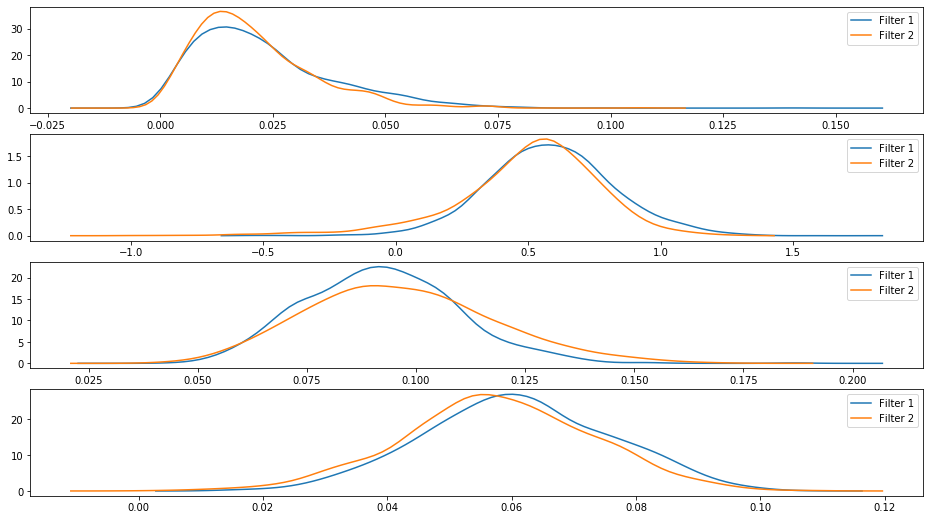

In [9]:
from pyfilter.utils import normalize
import pandas as pd

fig, ax = plt.subplots(len(alg.filter.ssm.theta_dists), figsize=(16, 9))
for r, alg in enumerate(algs):
    if not hasattr(alg, '_w_rec'):
        w = normalize(alg._ness._w_rec)
    else:
        w = normalize(alg._w_rec)
    
    for i, param in enumerate(alg.filter.ssm.theta_dists):    
        xrange, xvals = param.get_plottable(weights=w, transformed=False)

        mean = (w * param).sum()
        std = (w * (param - mean) ** 2).sum().sqrt()
     
        ax[i].plot(xrange, xvals, label='Filter {:d}'.format(r+1))

        ax[i].legend()

Let's plot a crude estimate of the underlying volatility. I say crude here because we uniformly weight the trajectories.

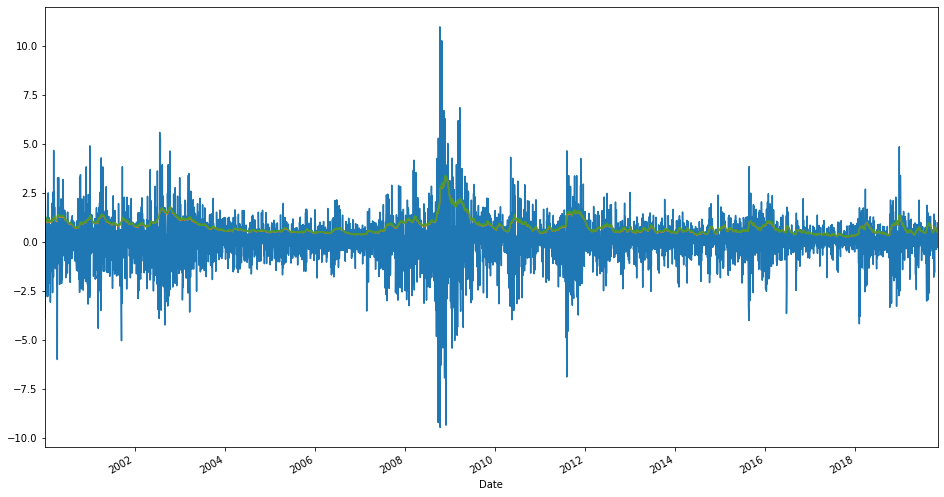

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
y.iloc[:training.shape[0]].plot(ax=ax)

for alg in algs:
    asdf = pd.DataFrame((-alg.filter.filtermeans).exp().cpu().numpy(), index=y.index[:training.shape[0]])

    asdf.mean(1).plot(alpha=0.75, ax=ax)

A plot over the ESS.

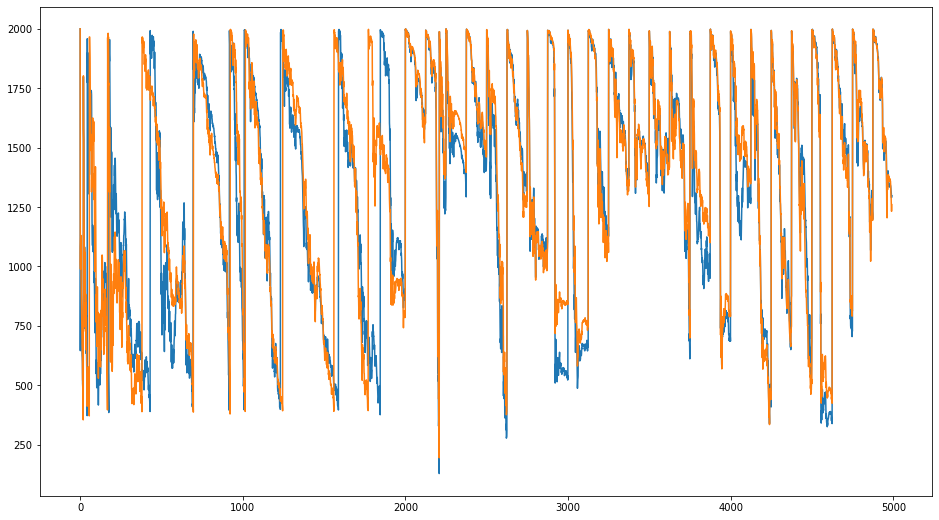

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
for alg in algs:
    ax.plot(alg.logged_ess.cpu().numpy())